In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2

In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

ndata_train = x_train.shape[0]
ndata_test = x_test.shape[0]

x_train = x_train.reshape((ndata_train,28,28,1))
x_test = x_test.reshape((ndata_test,28,28,1))

xshape = x_train.shape[1:4]

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Load and preprocess data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))
xshape = x_train.shape[1:]

# Model configuration
CNNModel = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation=tf.nn.relu,input_shape=xshape),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation=tf.nn.relu),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation=tf.nn.relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=2),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l1(0.0002)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(64, activation=tf.nn.softplus, kernel_regularizer=tf.keras.regularizers.l1(0.0005)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

CNNModel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ReduceLROnPlateau callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0005)
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

CNNModel.summary()

# Fit the model with the ReduceLROnPlateau callback
CNNModel.fit(x_train, y_train, epochs=30, validation_split=0.2, batch_size=500, callbacks=[reduce_lr, early_stopping])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        2320      
                                                                 
 batch_normalization (Batch  (None, 24, 24, 16)        64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 12, 12, 16)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 32)        4

In [ ]:
# predicted probabilities for test data
y_test_prob = CNNModel.predict(x_test)

# final prediction
y_test_pred = y_test_prob.argmax(axis=1)

from sklearn.metrics import accuracy_score
print('Accuracy on Test Dataset for CNN', round(100*accuracy_score(y_test, y_test_pred), 2), '%')


313/313 [==============================] - 1s 4ms/step
Accuracy on Test Dataset for CNN 99.46 %


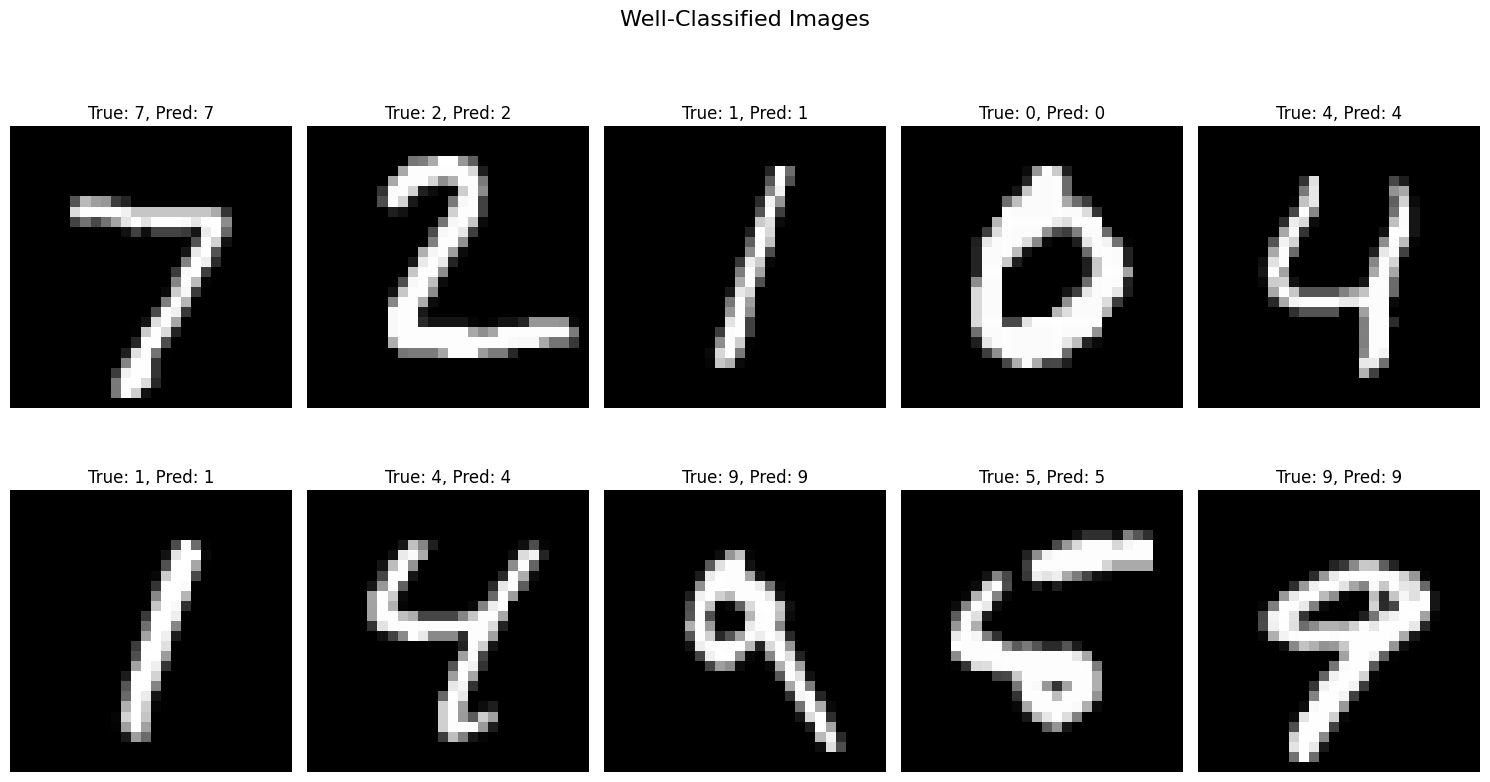

In [ ]:
#Miscalssification
import numpy as np
import matplotlib.pyplot as plt

# Find the indices of correctly classified images
correct_indices = np.where(y_test_pred == y_test)[0]

# Plot a few of the well-classified numbers
plt.figure(figsize=(15, 8))  # Increase the figure size to fit more images

# Display 10 well-classified images
for i, correct_index in enumerate(correct_indices[:10]):  # Adjust the number of images you want to display
    plt.subplot(2, 5, i + 1)  # Adjust for 10 images; 2 rows and 5 columns
    plt.imshow(np.squeeze(x_test[correct_index]), cmap='gray')
    plt.title(f"True: {y_test[correct_index]}, Pred: {y_test_pred[correct_index]}")
    plt.axis('off')

plt.tight_layout()
plt.suptitle('Well-Classified Images', fontsize=16, y=1.05)
plt.show()



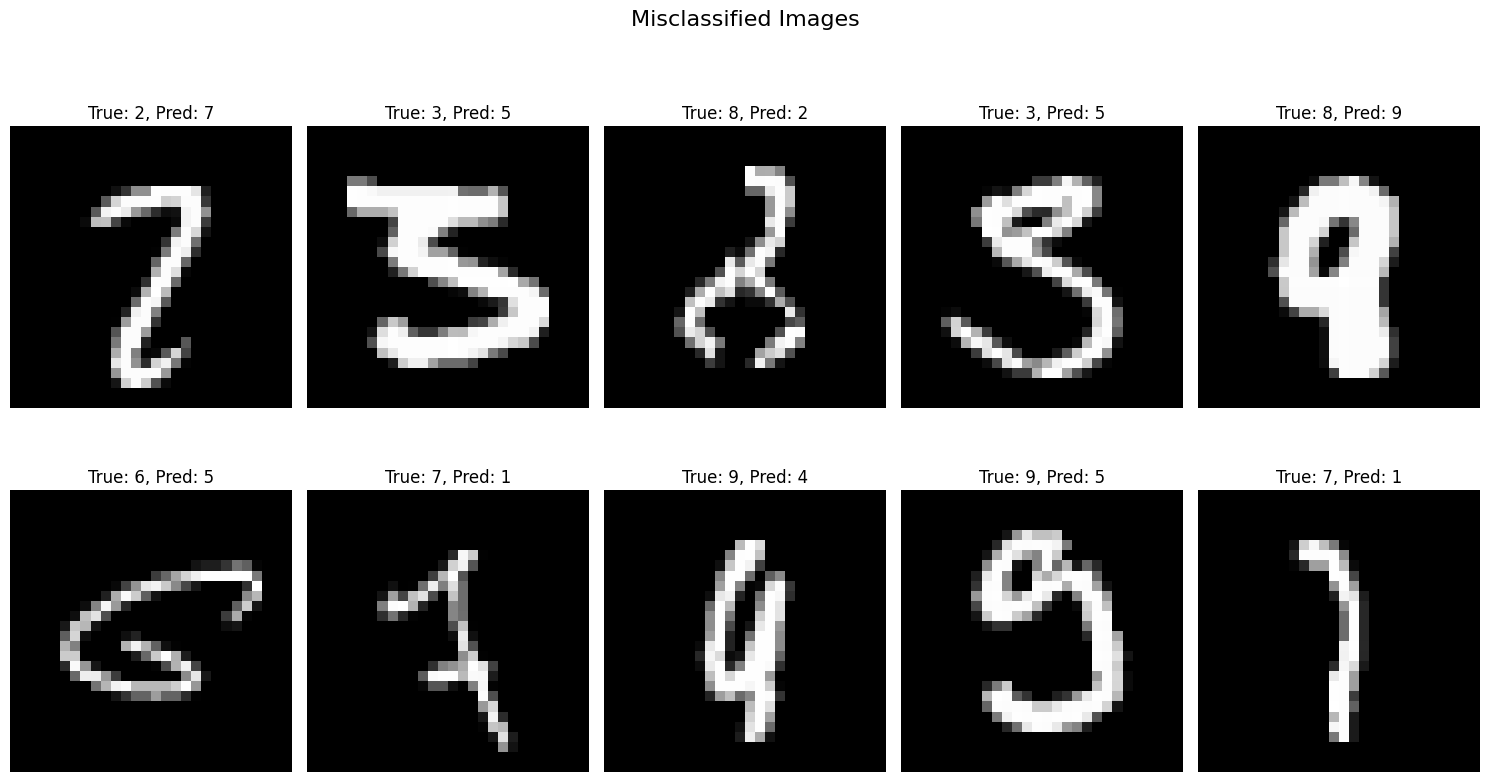

In [ ]:
# Find the indices of the test set where predictions don't match the true labels
misclassified_indices = np.where(y_test_pred != y_test)[0]

# Display 10 misclassified images (from the previous code)
plt.figure(figsize=(15, 8))  # Increase the figure size to fit more images

for i, misclassified_index in enumerate(misclassified_indices[:10]):  # Adjust the number of images you want to display
    plt.subplot(2, 5, i + 1)  # Adjust for 10 images; 2 rows and 5 columns
    plt.imshow(np.squeeze(x_test[misclassified_index]), cmap='gray')
    plt.title(f"True: {y_test[misclassified_index]}, Pred: {y_test_pred[misclassified_index]}")
    plt.axis('off')

plt.tight_layout()
plt.suptitle('Misclassified Images', fontsize=16, y=1.05)
plt.show()


In [ ]:
print(f"Total well-classified images: {len(correct_indices)}")
print(f"Total misclassified images: {len(misclassified_indices)}")

Total well-classified images: 9946
Total misclassified images: 54


In [ ]:
from collections import Counter

# Pair true and predicted labels for misclassified digits
misclassified_pairs = list(zip(y_test[misclassified_indices], y_test_pred[misclassified_indices]))

# Count the most common pairs
common_misclassifications = Counter(misclassified_pairs).most_common()

print("Most common misclassifications:")
for (true_label, pred_label), count in common_misclassifications:
    print(f"True: {true_label}, Pred: {pred_label} - Count: {count}")

Most common misclassifications:
True: 7, Pred: 1 - Count: 4
True: 9, Pred: 4 - Count: 4
True: 2, Pred: 7 - Count: 3
True: 3, Pred: 5 - Count: 3
True: 5, Pred: 3 - Count: 3
True: 6, Pred: 0 - Count: 3
True: 7, Pred: 2 - Count: 3
True: 8, Pred: 2 - Count: 2
True: 9, Pred: 5 - Count: 2
True: 3, Pred: 7 - Count: 2
True: 8, Pred: 3 - Count: 2
True: 4, Pred: 9 - Count: 2
True: 9, Pred: 0 - Count: 2
True: 9, Pred: 7 - Count: 2
True: 6, Pred: 8 - Count: 2
True: 8, Pred: 9 - Count: 1
True: 6, Pred: 5 - Count: 1
True: 5, Pred: 7 - Count: 1
True: 0, Pred: 6 - Count: 1
True: 2, Pred: 0 - Count: 1
True: 6, Pred: 1 - Count: 1
True: 1, Pred: 2 - Count: 1
True: 0, Pred: 2 - Count: 1
True: 9, Pred: 8 - Count: 1
True: 3, Pred: 1 - Count: 1
True: 8, Pred: 7 - Count: 1
True: 3, Pred: 8 - Count: 1
True: 0, Pred: 7 - Count: 1
True: 6, Pred: 4 - Count: 1
True: 5, Pred: 6 - Count: 1


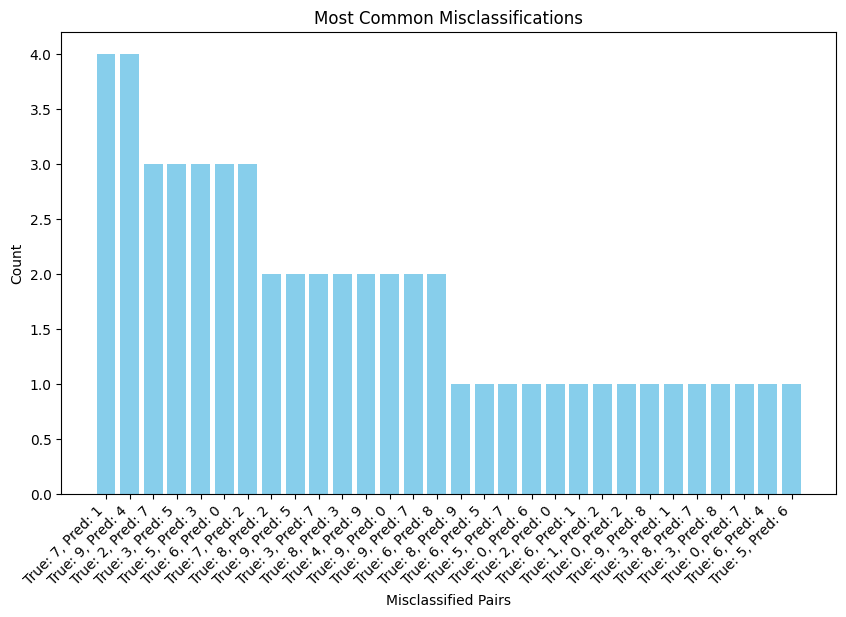

In [ ]:
import matplotlib.pyplot as plt

# Extract the pairs and counts
labels, counts = zip(*[(f"True: {t}, Pred: {p}", c) for ((t, p), c) in common_misclassifications])

# Plotting
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(labels, counts, color='skyblue')  # You can choose a different color
plt.xlabel('Misclassified Pairs')
plt.ylabel('Count')
plt.title('Most Common Misclassifications')
plt.xticks(rotation=45, ha='right')  # Rotate labels to fit and align properly
plt.show()


**Transformer**

In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
class ClassToken(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value = w_init(shape=(1, 1, input_shape[-1]), dtype=tf.float32),
            trainable = True
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        hidden_dim = self.w.shape[-1]

        cls = tf.broadcast_to(self.w, [batch_size, 1, hidden_dim])
        cls = tf.cast(cls, dtype=inputs.dtype)
        return cls

In [ ]:
def build_ViT(n,m,block_size,hidden_dim,num_layers,num_heads,key_dim,mlp_dim,dropout_rate,num_classes):
    # n is number of rows of blocks
    # m is number of cols of blocks
    # block_size is number of pixels (with rgb) in each block -> 4x4 = 16
    # hidden_dim -> size of the vector of the 0-10 processed image after first dense layer
    # num_heads -> number of multiple head(query, key, value) self attendtion
    # key_dim -> output dimension


    inp = tf.keras.layers.Input(shape=(n*m,block_size))
    # second input layer -> give the sequence to vectors
    inp2 = tf.keras.layers.Input(shape=(n*m))

    mid = tf.keras.layers.Dense(hidden_dim)(inp) # transform to vectors with different dimension
    # the positional embeddings
#     positions = tf.range(start=0, limit=n*m, delta=1)
    emb = tf.keras.layers.Embedding(input_dim=n*m, output_dim=hidden_dim)(inp2) # learned positional embedding for each of the n*m possible possitions

    #combine vector and its position information together
    mid = mid + emb # for some reason, tf.keras.layers.Add causes an error, but + doesn't?

    # create and append class token to beginning of all input vectors
    token = ClassToken()(mid) # append class token to beginning of sequence
    mid = tf.keras.layers.Concatenate(axis=1)([token, mid])

    for l in range(num_layers): # how many Transformer Head layers are there?
        ln  = tf.keras.layers.LayerNormalization()(mid) # normalize
        mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads,key_dim=key_dim,value_dim=key_dim)(ln,ln,ln) # self attention! - same input (query, key, value) !
        add = tf.keras.layers.Add()([mid,mha]) # add and norm
        ln  = tf.keras.layers.LayerNormalization()(add)
        den = tf.keras.layers.Dense(mlp_dim,activation='gelu')(ln) # maybe should be relu...who knows...
        den = tf.keras.layers.Dropout(dropout_rate)(den) # regularization
        den = tf.keras.layers.Dense(hidden_dim)(den) # back to the right dimensional space
        den = tf.keras.layers.Dropout(dropout_rate)(den)
        mid = tf.keras.layers.Add()([den,add]) # add and norm again
    ln = tf.keras.layers.LayerNormalization()(mid)
    fl = ln[:,0,:] # just grab the class token for each image in batch
    clas = tf.keras.layers.Dense(num_classes,activation='softmax')(fl) # probability that the image is in each category
    mod = tf.keras.models.Model([inp,inp2],clas)
    mod.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return mod

In [ ]:
n=7
m=7
block_size = 16
hidden_dim = 512
num_layers = 16
num_heads = 4
key_dim = hidden_dim//num_heads
mlp_dim = 256
dropout_rate = 0.2
num_classes = 10



trans = build_ViT(n,m,block_size,hidden_dim,num_layers,num_heads,key_dim,mlp_dim,dropout_rate,num_classes)
trans.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 49, 16)]             0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 49)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 49, 512)              8704      ['input_1[0][0]']             
                                                                                                  
 embedding (Embedding)       (None, 49, 512)              25088     ['input_2[0][0]']             
                                                                                              

In [ ]:
# param_grid = {
#     'hidden_dim': [32, 64, 128],
#     'num_layers': [8, 16],
#     'num_heads': [4, 8],
#     'key_dim': [16, 32],
#     'mlp_dim': [64, 128, 256],
#     'dropout_rate': [0.1, 0.2]
# }


In [ ]:
# from sklearn.model_selection import GridSearchCV
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

ndata_train = x_train.shape[0]
ndata_test = x_test.shape[0]

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
x_train_ravel = np.zeros((ndata_train,n*m,block_size))
for img in range(ndata_train):
    ind = 0
    for row in range(n):
        for col in range(m):
            x_train_ravel[img,ind,:] = x_train[img,(row*4):((row+1)*4),(col*4):((col+1)*4)].ravel() # turn 4x4 to 16 numbers
            ind += 1

x_test_ravel = np.zeros((ndata_test,n*m,block_size))
for img in range(ndata_test):
    ind = 0
    for row in range(n):
        for col in range(m):
            x_test_ravel[img,ind,:] = x_test[img,(row*4):((row+1)*4),(col*4):((col+1)*4)].ravel()
            ind += 1

In [ ]:
pos_feed_train = np.array([list(range(n*m))]*ndata_train)
pos_feed_test = np.array([list(range(n*m))]*ndata_test)

In [ ]:
# grid_result = grid.fit([x_train_ravel, pos_feed_train], y_train)

In [ ]:
# best_model = grid_result.best_estimator_.model
# best_model.evaluate([x_test_ravel, pos_feed_test], y_test)


In [ ]:
trans.fit([x_train_ravel,pos_feed_train],y_train,epochs=80,batch_size = 400,validation_split=0.2)

Epoch 1/80
120/120 [==============================] - 173s 1s/step - loss: 1.8993 - accuracy: 0.3046 - val_loss: 1.0578 - val_accuracy: 0.6395
Epoch 2/80
120/120 [==============================] - 148s 1s/step - loss: 0.8134 - accuracy: 0.7281 - val_loss: 0.6599 - val_accuracy: 0.7866
Epoch 3/80
120/120 [==============================] - 147s 1s/step - loss: 0.6161 - accuracy: 0.7996 - val_loss: 0.5093 - val_accuracy: 0.8381
Epoch 4/80
120/120 [==============================] - 147s 1s/step - loss: 0.7156 - accuracy: 0.7623 - val_loss: 0.5692 - val_accuracy: 0.8107
Epoch 5/80
120/120 [==============================] - 146s 1s/step - loss: 0.7486 - accuracy: 0.7482 - val_loss: 0.7702 - val_accuracy: 0.7435
Epoch 6/80
120/120 [==============================] - 155s 1s/step - loss: 0.7953 - accuracy: 0.7395 - val_loss: 0.7032 - val_accuracy: 0.7674
Epoch 7/80
120/120 [==============================] - 146s 1s/step - loss: 0.6513 - accuracy: 0.7895 - val_loss: 0.6100 - val_accuracy: 0.8027

KeyboardInterrupt: 

In [ ]:
out = trans.evaluate([x_test_ravel,pos_feed_test],y_test)

313/313 [==============================] - 13s 41ms/step - loss: 0.0958 - accuracy: 0.9723


In [ ]:
out[1]

NameError: name 'out' is not defined

**CODE FROM ANMOL**

In [ ]:
#CNN model implementation
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
%matplotlib inline

mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
ndata_train = x_train.shape[0]
ndata_test = x_test.shape[0]

x_train = x_train.reshape((ndata_train,28,28,1))
x_test = x_test.reshape((ndata_test,28,28,1))
xshape = x_train.shape[1:4]

# model = models.Sequential([
#   layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
#   layers.MaxPooling2D((2, 2)),
#   layers.Conv2D(64, (3, 3), activation='relu'),
#   layers.MaxPooling2D((2, 2)),
#   layers.Conv2D(64, (3, 3), activation='relu'),
#   layers.Flatten(),
#   layers.Dense(64, activation='relu'),
#   layers.Dense(64, activation='relu'),
#   layers.Dropout(0.2),
#   layers.Dense(10, activation='softmax')
# ])




model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train,y_train,epochs=10,validation_split=0.2,batch_size=200)


In [ ]:
#Using the CNN model on entire dataset
Model.fit(x_train,y_train,epochs=12,validation_split=0,batch_size=200)

# predicted probabilities for test data
y_test_prob = Model.predict(x_test)

# final prediction
y_test_pred = y_test_prob.argmax(axis=1)

from sklearn.metrics import accuracy_score
print('Accuracy on Test Dataset', round(100*accuracy_score(y_test, y_test_pred), 2), '%')


In [ ]:
#Miscalssification
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the test dataset loaded as x_test and y_test
# And your model's predictions are stored in y_test_pred

# Find the indices of the test set where predictions don't match the true labels
misclassified_indices = np.where(y_test_pred != y_test)[0]



# Plot a few of the misclassified numbers
plt.figure(figsize=(15, 8))  # Increase the figure size to fit 20 images
for i, misclassified_index in enumerate(misclassified_indices[:20]):  # Change 10 to 20 here
    plt.subplot(4, 5, i + 1)  # Change the subplot grid to 4 rows by 5 columns
    plt.imshow(np.squeeze(x_test[misclassified_index]), cmap='gray')
    plt.title(f"True: {y_test[misclassified_index]}, Pred: {y_test_pred[misclassified_index]}")
    plt.axis('off')

plt.tight_layout()
plt.show()
len(misclassified_indices) #misclassified images

In [ ]:
from collections import Counter

# Pair true and predicted labels for misclassified digits
misclassified_pairs = list(zip(y_test[misclassified_indices], y_test_pred[misclassified_indices]))

# Count the most common pairs
common_misclassifications = Counter(misclassified_pairs).most_common()

print("Most common misclassifications:")
for (true_label, pred_label), count in common_misclassifications:
    print(f"True: {true_label}, Pred: {pred_label} - Count: {count}")

**Anvil code**

In [ ]:
# pip install anvil-uplink

In [ ]:
import anvil.server
import anvil.media
anvil.server.connect("server_P2HL6ACTFNLZQ4ZH4F2HDE6B-2PHMPKTANTLBSTAI")

In [ ]:
#function for proj 1

import numpy as np
import pandas as pd
# from PIL import Image
# from io import BytesIO
import tensorflow as tf
from tensorflow.keras.models import load_model

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

class ClassToken(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value = w_init(shape=(1, 1, input_shape[-1]), dtype=tf.float32),
            trainable = True
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        hidden_dim = self.w.shape[-1]

        cls = tf.broadcast_to(self.w, [batch_size, 1, hidden_dim])
        cls = tf.cast(cls, dtype=inputs.dtype)
        return cls


custom_obj={'ClassToken' : ClassToken}

#load
trans=load_model('model_x.h5', custom_objects=custom_obj) # transformer

#cnn model
# Define the CNN model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

cnn = tf.keras.models.load_model('my_mnist_model.h5')



df=pd.read_csv('output.csv', header=None)
# file= file.get_bytes()
# df=pd.read_csv(BytesIO(file), header=None)
np_df=np.array(df)

def proj_fxn(np_df):
  if np_df.shape != (28,28):
    return "CSV file must be (28,28) Please try again",""


  maximum= np.max(np_df)
  if maximum >1:
    np_df= np_df / 255

  x_train_ravel = np.zeros((1,7*7,16))
  ind = 0
  for row in range(7):
      for col in range(7):
          x_train_ravel[0,ind,:] = np_df[(row*4):((row+1)*4),(col*4):((col+1)*4)].ravel()
          ind += 1

  pos_feed_train=np.array([list(range(7*7))])

  out=trans.predict([x_train_ravel, pos_feed_train])

  pred_class= np.argmax(out, axis=1) # transformer label

  # cnn prediction
  prob = cnn.predict(np_df.reshape(1,28,28,1))
  result_cnn = np.argmax(prob) # cnn label

  return str(pred_class)[1], str(result_cnn)




In [ ]:
proj_fxn(np_df)

In [ ]:
def convert_array(path):
  df = pd.read_csv(path, header=None)
  np_df=np.array(df)
  return np_df

In [ ]:
np_df.shape

In [ ]:
def save_image(image_array):
    plt.imshow(image_array.squeeze(), cmap='gray')
    plt.axis('off')
    plt.savefig("foo.png")

In [ ]:
# @anvil.server.callable

# def convert(file):
#   file= file.get_bytes()
#   df=pd.read_csv(BytesIO(file), header=None)
#   np_df=np.array(df)

#   image= Image/fromarray(np_df)
#   image2= image.convert("L")
#   bytess=BytesIO()
#   image2.save(bytess, format='JPEG')

#   return anvil.BlobMedia('image/jpeg', bytess.getvalue(), name='Uplaod_Image')

In [ ]:
def get_result(image_array):
    prob = loaded_model.predict(image_array)
    result = np.argmax(prob)
    return result

In [ ]:
@anvil.server.callable
def get_png_image(file_name):
    with open(file_name, 'rb') as f:
        return anvil.BlobMedia("image/png", f.read())

In [ ]:
@anvil.server.callable
def model_run(path):
    with anvil.media.TempFile(path) as filename:
        np_df = convert_array(filename)
        save_image(np_df)
        result1,result2 = proj_fxn(np_df)
        return ('Predicted Number is: {}'.format(result1)), ('Predicted Number is: {}'.format(result2))